In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import random
from math import ceil, floor
import yaml

# from mc_utilities import (
#     mc_utilities_pk,
#     mc_utilities_op,
#     mc_probs_pk,
#     mc_probs_op,
#     dc_utility,
# )
from utils import post_processing
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import geopandas as gpd
from trip_prediction import trip_prediction
from shapely.geometry import Point, shape, Polygon
from shapely.ops import unary_union

import shapely.speedups
import networkx as nx

shapely.speedups.disable()

In [2]:
id_converter = pickle.load(open(r"Data\id_converter.p", "rb"))

In [3]:
# Load data
mc_fileloc = r"mc_input_data\\"
per_dist = pd.read_csv(mc_fileloc + "dists_dat.csv", sep=",")
per_emp = pd.read_csv(mc_fileloc + "dests_emp.csv", sep=",")
mdot_dat = pd.read_csv(mc_fileloc + "mdot_trips_dc.csv", sep=",")
dests_geo = pd.read_csv(mc_fileloc + "dests_geoid.csv", sep=",")
D = pd.read_csv(mc_fileloc + "distance.csv", sep=",", index_col=[0])

In [4]:
(trips_mat_pk,
 trips_mat_op,
 transit_trips_mat_pk,
 transit_trips_mat_op,
 ) = trip_prediction(id_converter, per_dist, per_emp, mdot_dat, dests_geo, D)

In [5]:
transit_trip_pk = np.zeros((len(id_converter), len(id_converter)))
transit_trip_op = np.zeros((len(id_converter), len(id_converter)))

In [6]:
for i in range(len(id_converter)):
    for j in range(len(id_converter)):
        transit_trip_pk[i, j] = transit_trips_mat_pk[i, j]
        transit_trip_op[i, j] = transit_trips_mat_op[i, j]

In [7]:
trips_df = pd.DataFrame(
    index=np.arange(len(id_converter)),
    columns=[
        "trips_pk_in",
        "trips_pk_out",
        "trips_op_in",
        "trips_op_out",
        "transit_trips_pk_in",
        "transit_trips_pk_out",
        "transit_trips_op_in",
        "transit_trips_op_out",
    ],
)

In [10]:
for i in range(len(id_converter)):
    trips_df.loc[i, "trips_pk_in"] = sum(
        v for (k, v) in trips_mat_pk.items() if k[1] == i
    )
    trips_df.loc[i, "trips_op_in"] = sum(
        v for (k, v) in trips_mat_op.items() if k[1] == i
    )
    trips_df.loc[i, "trips_pk_out"] = sum(
        v for (k, v) in trips_mat_pk.items() if k[0] == i
    )
    trips_df.loc[i, "trips_op_out"] = sum(
        v for (k, v) in trips_mat_op.items() if k[0] == i
    )

    trips_df.loc[i, "transit_trips_pk_in"] = sum(
        v for (k, v) in transit_trips_mat_pk.items() if k[1] == i
    )
    trips_df.loc[i, "transit_trips_op_in"] = sum(
        v for (k, v) in transit_trips_mat_op.items() if k[1] == i
    )
    trips_df.loc[i, "transit_trips_pk_out"] = sum(
        v for (k, v) in transit_trips_mat_pk.items() if k[0] == i
    )
    trips_df.loc[i, "transit_trips_op_out"] = sum(
        v for (k, v) in transit_trips_mat_op.items() if k[0] == i
    )
trips_df.index.name = "zone_id"

In [14]:
temp1 = {v for (k, v) in transit_trips_mat_pk.items() if k[0] == k[1]}
temp1

{0.0,
 0.3831369912819637,
 0.4614279271508503,
 0.6418705631593008,
 0.7160177464317707,
 0.7328465816742162,
 0.7741568915439245,
 0.8375515576236882,
 1.1167066356908182,
 1.411146600774518,
 1.5456124558473257,
 1.5932561374779493,
 1.693108417415378,
 1.7762407852071123,
 1.8070622299898822,
 1.9575894462158188,
 2.0609139231616282,
 2.1935552433302554,
 2.359156233309453,
 2.9602360707734743}

In [21]:
temp2 = {k: v for (k, v) in transit_trips_mat_pk.items()
         if v > 0
         if (k[1], k[0]) in transit_trips_mat_pk
         if transit_trips_mat_pk[k[1], k[0]] > 0
         if k[1] != k[0]}
temp2

{(1, 39): 2.5992919824304,
 (17, 20): 0.3300326754287719,
 (18, 19): 2.2671027255391216,
 (18, 20): 2.262132286413095,
 (19, 18): 1.1972989220772345,
 (19, 20): 1.5425383349077744,
 (19, 22): 1.888642336318531,
 (20, 17): 0.690821243662591,
 (20, 18): 1.0181449052834577,
 (20, 19): 2.7747574006205378,
 (20, 21): 6.2320528431762545,
 (20, 22): 0.8117763353788515,
 (21, 20): 2.289964994112635,
 (22, 19): 4.680410844151183,
 (22, 20): 4.604290747274385,
 (29, 52): 3.041862057982769,
 (32, 65): 1.3956270130349264,
 (39, 1): 3.846683580970676,
 (52, 29): 0.8187686274889837,
 (52, 53): 1.9646588939380671,
 (53, 52): 2.945565982325784,
 (65, 32): 0.9443549443898308}

In [34]:
print(sum(transit_trips_mat_pk.values()),
      max(sum(transit_trips_mat_pk[i, j]
              for j in range(69)) for i in range(69)),
      np.argmax([sum(transit_trips_mat_pk[i, j]
                     for j in range(69)) for i in range(69)]),
      max(sum(transit_trips_mat_pk[i, j]
              for i in range(69)) for j in range(69)),
      np.argmax([sum(transit_trips_mat_pk[i, j]
                     for i in range(69)) for j in range(69)]),
      )

909.5352504637999 66.60317340614317 20 96.53421614274197 18


In [40]:
print("original: {}, ceiling: {}, rounding: {}, random: {}".format(sum(transit_trips_mat_pk.values()),
                                                                   sum([
                                                                       ceil(v) for v in transit_trips_mat_pk.values()]),
                                                                   sum([
                                                                       round(v) for v in transit_trips_mat_pk.values()]),
                                                                   sum([ceil(v) if random.randint(0, 1) else floor(
                                                                       v) for v in transit_trips_mat_pk.values()])
                                                                   )
      )

original: 909.5352504637999, ceiling: 1000, rounding: 915, random: 906


# QGIS Code for virtual layer (flow map arrow)

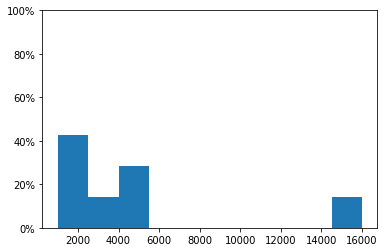

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

data = [1000, 1000, 5000, 3000, 4000, 16000, 2000]

plt.hist(data, weights=np.ones(len(data)) / len(data))

plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.gca().set_ylim(bottom=0,top=1.00)
plt.show()


# Plot routes

In [2]:
with open("config.yaml", "r+") as fopen:
    config = yaml.load(fopen, Loader=yaml.FullLoader)
gpd_shp_file = gpd.read_file(config["shapefile_zone_id"])
gpd_shp_file_summary = gpd_shp_file.geometry.bounds
lolon, uplon, lolat, uplat = (
    gpd_shp_file_summary.minx.min(),
    gpd_shp_file_summary.maxx.max(),
    gpd_shp_file_summary.miny.min(),
    gpd_shp_file_summary.maxy.max(),
)

bm = Basemap(
    llcrnrlon=lolon,
    llcrnrlat=lolat,
    urcrnrlon=uplon,
    urcrnrlat=uplat,
    resolution="i",
    projection="tmerc",
        lat_0=sum([uplat, lolat]) / 2.0,
        lon_0=sum([uplon, lolon]) / 2.0,
)

Route_D = pickle.load(open(r"Data\temp\Route_D.p", "rb"))
Route_D_disagg = post_processing(Route_D, config)

In [3]:
lons_dict = {idx: c.x for idx, c in zip(gpd_shp_file.zone_id, gpd_shp_file.centroid)}
lats_dict = {idx: c.y for idx, c in zip(gpd_shp_file.zone_id, gpd_shp_file.centroid)}

duration_d = dict()
for d, route in Route_D_disagg.items():
    os = route[0][2]
    for idx, stamp in enumerate(route):
        if idx > 0 and stamp[2] == os:
            duration_d[d] = stamp[1]
            break
s_list = {
    d: [
        (lons_dict[n1], lats_dict[n1])
        for (_, t2, n1, _, _, _) in route
        if t2 <= duration_d[d]
    ]
    for d, route in Route_D_disagg.items()
}

for d, s in s_list.items():
    lons, lats = [c[0] for c in s], [c[1] for c in s]
    x, y = bm(lons, lats)
    fig = plt.figure(figsize=(30, 25))
    ax = fig.gca()
    bm.readshapefile(
        config["shapefile_zone_id"][:-4],
        "zone_id",
        ax=ax,
        linewidth=1,
    )
    bm.plot(
        x,
        y,
        color="black",
        ax=ax,
        linewidth=3.0,
    )
    fig.savefig(
        config["figure_pth"] + r"route_{}.png".format(d), bbox_inches="tight", dpi=100
    )
    plt.close()

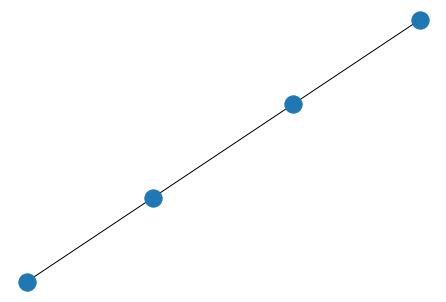

In [3]:
G=nx.Graph()
G.add_edges_from([('A','B'),('A','C'),('B','D'),])
nx.draw(G)
plt.show()

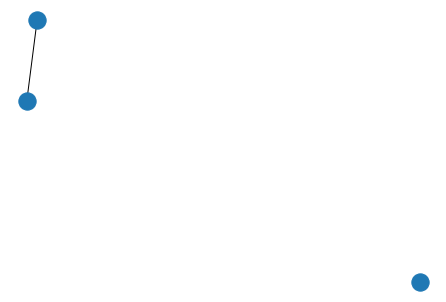

In [4]:
G.remove_node('B')
nx.draw(G)
plt.show()